In [1]:
from torchvision import transforms
from torchvision.models import *
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchvision
import wandb
import os
import warnings
import torch.nn as nn
from torchsummary import summary
from torch.distributions import Normal, Independent, kl, MultivariateNormal
from typing import Optional, List
from torch import Tensor
import math
import time
from Variational_transformer import *
from cityscapesscripts.helpers.labels import labels as city_labels
from torchvision.datasets import Cityscapes
from Transformer import *
from VAE import *
from PIL import Image, ImageDraw
import glob
import json
import re
from torchvision import transforms
from dataloader_cityscapes import *
import random
import torchvision.transforms.functional as TF
device = torch.device("cuda:0")
%matplotlib inline
warnings.filterwarnings("ignore")

## Cityscapes API dataloader

In [2]:
dataset = Cityscapes('../datasets/Cityscapes/', split='train', mode='fine', target_type='semantic')
len(dataset)

2975

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


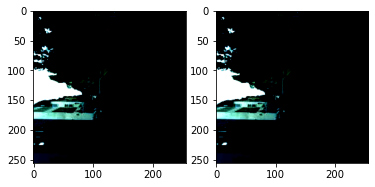

In [21]:
preprocess_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_ou = transforms.Compose([
    transforms.ToTensor(),
])


tr_loader = CityscapesLoader("../datasets/augmented_cityscapes", transform_in = preprocess_in, transform_ou = preprocess_ou)
train_loader = DataLoader(dataset = tr_loader, batch_size = 50, shuffle = True)



for i in train_loader:
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(i["image"][0].permute(2,1,0))
    axarr[1].imshow(i["image"][0].permute(2,1,0))
    break

## Transformer model time measure

In [ ]:
input_image = torch.randn(50, 3, 256, 256)
input_seg = torch.randn(50, 3, 256, 256)
input_posterior = torch.randn(50, 6, 256, 256)
mask = torch.randn(50, 3, 256, 256)
tmp = torch.randn(50, 10, 1000)

In [ ]:
VT = VariationalTransformer(**{"input_img_dim":[256,256], "transformer_emb_dim":256, "transformer_num_heads":2,
                       "transformer_num_encoder_layer": 1, "transformer_num_dec_layer": 1, 
                       "transformer_intermediate_layer_dim": 512, "transformer_dropout_per":0,
                       "prior_input_channels":3, "prior_posterior_layers":[64,128,256],
                       "posterior_input_channels":6, "prior_posterior_layers":[64,128,256], "batch_size":50})

In [ ]:
start = time.time()
out = VT(input_image, input_seg)
end = time.time()
print(end - start)

In [ ]:
start = time.time()
for i in VT.inference(torch.randn(1, 3, 256, 256)):
    print(i.shape)
end = time.time()
print(end - start)

## My own dataloader

In [17]:
def find_color(label):
    for i in range(len(city_labels)):
        if label == city_labels[i].name:
            return list(city_labels[i].color)

In [18]:
def generate_prob_mask(img, seg_mask, json_obj, label_to_id, num_classes = 35):
    
    segments = []
    prob_mask = np.zeros((img.shape[0], img.shape[1], num_classes))
    
    for label in json_obj['objects']:
        label = label['label']
        if "group" in label:
            label = re.sub("group", "", label)
        color = find_color(label)
        color.append(255)
        mask = (seg_mask == color).all(-1)
        tmp = np.zeros((num_classes))
        tmp[label_to_id[label]] = 1
        prob_mask[mask] = tmp
        
    return prob_mask

../datasets/Cityscapes/leftImg8bit/train/weimar/weimar_000083_000019_leftImg8bit.png
../datasets/Cityscapes/gtFine/train/weimar/weimar_000083_000019_gtFine_color.png
../datasets/Cityscapes/gtFine/train/weimar/weimar_000083_000019_gtFine_polygons.json
../datasets/Cityscapes/gtFine/train/weimar/weimar_000083_000019_gtFine_prob_mask.
1.6741809844970703


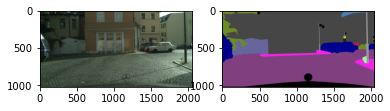

In [19]:
start = time.time()

mode = 'train'
add = "../datasets/Cityscapes/leftImg8bit/{}/*".format(mode)
label_to_id = {label.name:i for i,label in enumerate(city_labels)}
for folder in glob.iglob(add):
    for file in glob.iglob(os.path.join(folder,"*")):
        
        img_add = file
        gtFine = img_add.replace("leftImg8bit", "gtFine_color")
        gtFine = gtFine.replace("gtFine_color", "gtFine", 1)
        json_add = gtFine.replace("color", "polygons")
        json_add = json_add.replace("png", "json")
        
        img = np.array(Image.open(img_add))
        seg_mask = np.array(Image.open(gtFine))
        json_obj = json.load(open(json_add))
        
        label = generate_prob_mask(img, seg_mask, json_obj, label_to_id)
        label_add = gtFine.replace("gtFine_color", "gtFine_prob_mask")
        label_add = label_add.replace("png", "")
        np.save(label_add, label)
        
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img)
        axarr[1].imshow(seg_mask)
        print(img_add)
        print(gtFine)
        print(json_add)
        print(label_add)
        
        
        
        break
    break
    
end = time.time()
print(end - start)

## Data augmentation

In [8]:
class RandomErasing:


    def __call__(self, x):
        
        if not isinstance(x, torch.Tensor):
            x = transforms.ToTensor()(x)
        x = transforms.ToPILImage()(transforms.RandomErasing(p=1.)(x))
        return x 
    


In [9]:
class RandomAffine:

    def __init__(self, angles = (0,360), translate = (2,2), scale = (0,2), shear = (-180,180)):
        self.angle_range = angles
        self.translate = translate
        self.scale_range = scale
        self.shear_range = shear
        self.__new_seed__()

    def __call__(self, x):
        return TF.affine(x, self.angle, self.translate, self.scale, self.shear)
    
    def __new_seed__(self):
        self.angle = random.uniform(*self.angle_range)
        self.scale = random.uniform(*self.scale_range)
        self.shear = random.uniform(*self.shear_range)

In [10]:
customized_augment_transforms = [
    transforms.ColorJitter(brightness = (0.5,2), contrast = (0.5,2), saturation = (0.5,2), hue = (-0.5,0.5)),
    RandomErasing(),
    transforms.GaussianBlur(9),
    transforms.Grayscale(num_output_channels = 3),
    RandomAffine(angles = (0,360), translate = (0.5,2), scale = (0.5,2), shear = (0,30))
]


In [13]:
start = time.time()
#data_set_mode = "color"
data_set_mode = "labelIds"
count_img = 0
count_mask = 0
mode = 'test'
save_img_add = "../datasets/augmented_cityscapes/images/{}/".format(mode)
save_mask_add = "../datasets/augmented_cityscapes/masks/{}/".format(mode)
add = "../datasets/Cityscapes/leftImg8bit/{}/*".format(mode)
final_image_dim = (256, 256)


for folder in glob.iglob(add):
    for file in glob.iglob(os.path.join(folder,"*")):
        

        img_add = file
        print(img_add)
        gtFine = img_add.replace("leftImg8bit", "gtFine_{}".format(data_set_mode))
        gtFine = gtFine.replace("gtFine_{}".format(data_set_mode), "gtFine", 1)


        img = Image.open(img_add)
        input_image_shape = np.array(img).shape
        transforms.Resize(final_image_dim)(img).save(save_img_add + "{}.jpg".format(str(count_img).zfill(6)))
        count_img += 1
        img = transforms.FiveCrop((int(input_image_shape[0]/2), int(input_image_shape[1]/2)))(img)
        
        seg_mask = Image.open(gtFine)
        transforms.Resize(final_image_dim)(seg_mask).save(save_mask_add + "{}.jpg".format(str(count_mask).zfill(6)))
        count_mask += 1
        seg_mask = transforms.FiveCrop((int(input_image_shape[0]/2), int(input_image_shape[1]/2)))(seg_mask)
        
        for i in range(len(img)):
            
            transf = random.choice(customized_augment_transforms)
            if hasattr(transf, '__new_seed__'):
                transf.__new_seed__()
            
            tmp_img = transforms.Resize(final_image_dim)(img[i])
            tmp_img.save(save_img_add + "{}.jpg".format(str(count_img).zfill(6)))
            count_img += 1
            transf(tmp_img).save(save_img_add + "{}.jpg".format(str(count_img).zfill(6)))
            count_img += 1
            
            tmp_mask = transforms.Resize(final_image_dim)(seg_mask[i])
            tmp_mask.save(save_mask_add + "{}.jpg".format(str(count_mask).zfill(6)))

            count_mask += 1
            if isinstance(transf, RandomAffine):
                transf(tmp_mask).save(save_mask_add + "{}.jpg".format(str(count_mask).zfill(6)))

                count_mask += 1
            else:
                tmp_mask.save(save_mask_add + "{}.jpg".format(str(count_mask).zfill(6)))
                count_mask += 1
    
end = time.time()
#print(end - start)

../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_041142_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_040035_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_048754_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_039082_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_006603_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_043389_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_059729_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_061094_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_013665_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_001505_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_051223_leftImg8bit.png
../dataset

../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_003546_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_006239_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_008279_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_005068_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_040472_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_060786_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_043100_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_028747_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_041444_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_029148_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bielefeld/bielefeld_000000_025748_leftImg8bit.png
../dataset

../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000037_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000028_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000045_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000000_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000040_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000018_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000001_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000043_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000003_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000034_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000002_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/bonn/bonn_000019_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/

../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_032911_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_018249_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_038026_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_012995_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_004228_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_016083_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_048725_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_016542_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_012470_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_017618_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_007813_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_011965_leftImg8bit.png
../datasets/City

../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_004000_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_029755_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_038955_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_016708_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_008638_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_032567_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_027124_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_033329_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_010853_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000002_001871_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_004542_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_028566_leftImg8bit.png
../datasets/City

../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_014959_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_009751_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_045197_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_016011_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_022630_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_000093_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_011785_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000001_007460_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_001465_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_007144_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000000_021735_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/mainz/mainz_000003_016360_leftImg8bit.png
../datasets/City

../datasets/Cityscapes/leftImg8bit/test/munich/munich_000050_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000043_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000341_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000006_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000316_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000346_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000283_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000271_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000172_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000203_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000175_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000133_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/munich/munich_000262_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000372_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000150_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000100_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000319_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000294_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000246_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000097_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000356_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000177_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000361_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000369_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/munich/munich_000045_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000322_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000095_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000189_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000084_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000222_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000327_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000089_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000052_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000046_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000109_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000107_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/munich/munich_000373_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000090_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000141_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000275_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000288_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000208_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000161_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000380_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000230_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000105_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000239_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/munich/munich_000389_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000039_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000033_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000031_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000049_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000044_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000015_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000035_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000037_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000002_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/leverkusen/leverkusen_000005_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000092_000019_leftImg8bit.

../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000328_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000506_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000298_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000233_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000308_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000251_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000523_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000218_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000226_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000105_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000049_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000390_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000383_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000421_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000210_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000116_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000209_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000513_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000261_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000276_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000061_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000125_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000435_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000403_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000100_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000048_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000175_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000029_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000172_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000519_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000332_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000079_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000538_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000430_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000208_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000034_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000220_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000098_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000537_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000529_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000055_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000517_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000389_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000004_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000515_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000382_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000094_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000126_000019_leftImg8

../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000441_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000167_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000177_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000374_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000141_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000331_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000526_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000028_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000349_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000505_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000393_000019_leftImg8bit.png
../datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000304_000019_leftImg8

In [4]:
city_labels

[Label(name='unlabeled', id=0, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='ego vehicle', id=1, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='rectification border', id=2, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='out of roi', id=3, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='static', id=4, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='dynamic', id=5, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(111, 74, 0)),
 Label(name='ground', id=6, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(81, 0, 81)),
 Label(name='road', id=7, trainId=0, category='flat', categoryId=

In [15]:
def test(x:tuple):
    print(x)
    
test((1,2))

(1, 2)
